#### Eaters world

Like PACMAN where *eaters* 


we've got this move to food program but its dumb, only senses whats around it
this is a problem, the eater will stop when theres nothing immediately around it

p53 pic of not knowing what to do 




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src/')

from lib.pysoarlib import *
import os
from random import choice, randint

# Visualization
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from time import sleep

# Current working directory (.../tutorials)
cwd = os.path.abspath('')
font_sm = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 14, encoding="unic")

In [3]:
class Food():
    def __init__(self, bonus=False):
        self.points = 10   if bonus else 5
        self.color = 'red' if bonus else 'blue'
        self.bonus = bonus
    def __repr__(self):
        return 'bonusfood' if self.bonus else 'normalfood'
    
    
class Blank():
    def __init__(self):
        pass
    def __repr__(self):
        return 'blank'

    
class Wall():
    def __init__(self):
        pass
    def __repr__(self):
        return 'wall'

    
# action_space = ['north', 'east', 'south', 'west']
class World():    
    def __init__(self, display, width=300, height=300, rows=16, cols=16):
        self.n_rows = rows
        self.n_cols = cols
        self.width = width
        self.height = height
        
        # Initialize grid with walls/blank squares
        choices = [Wall(), Blank(), Blank(), Blank(), Blank()]
        self.grid = [[choice(choices) for x in range(cols)] for y in range(rows)] 

        # Fill the rest with food
        for row in range(rows):
            for col in range(cols):
                if isinstance(self.grid[row][col], Blank):
                    self.grid[row][col] = choice([Food(bonus=True), Food(bonus=False)])
            
        self.image = Image.new("RGBA", (self.width, self.height), (255, 255, 255, 0))
        self.canvas = ImageDraw.Draw(self.image)
        self.display = display
        self.cell_w = self.width / cols
        self.cell_h = self.width / rows
     
    def place_eaters(self, eaters):
        # Place the eaters randomly
        for eater in eaters:
            while True:
                row, col = randint(0, self.n_rows - 1), randint(0, self.n_cols - 1)
                if not isinstance(self.grid[row][col], Wall):
                    self.grid[row][col] = eater
                    break

    def step(self, ID: str, action = None):
        """ Returns (observations, reward) """
        ((row_n, col_n), cell) = self.find(ID)
        
        new_row = row_n
        new_col = col_n
        if action == 'north': new_row -= 1
        if action == 'south': new_row += 1
        if action == 'west' : new_col -= 1
        if action == 'east' : new_col += 1
        
        no_move = new_row == row_n and new_col == col_n
        if not self.is_valid_move(new_row, new_col) or no_move:
            # Don't move and return current observations
            return self.observations(row_n, col_n), 0
        
        if self.is_collision((row_n, col_n), (new_row, new_col)):
            raise Exception("no logic to handle collisions")
        else:        
            # aka reward
            points = 0
            if hasattr(self.grid[new_row][new_col], 'points'):
                points = self.grid[new_row][new_col].points
            self.grid[new_row][new_col] = self.grid[row_n][col_n]
            self.grid[row_n][col_n] = Blank()
            return self.observations(new_row, new_col), points


    def is_valid_move(self, row, col):
        # Out of bounds
        if row < 0 or col < 0 or row >= self.n_rows or col >= self.n_cols:
            return False
        is_wall = isinstance(self.grid[row][col], Wall)
        return not is_wall
        
    def is_collision(self, pos1, pos2):
        eater_1 = self.grid[pos1[0]][pos1[1]]
        eater_2 = self.grid[pos2[0]][pos2[1]]
        return isinstance(eater_1, Eater) and isinstance(eater_2, Eater) and eater_1.ID != eater_2.ID
        
    def observations(self, row, col):
        north = '' if row == 0           else self.grid[row - 1][col]
        south = '' if row >= self.n_rows-1 else self.grid[row + 1][col]
        east = ''  if col >= self.n_cols-1 else self.grid[row][col + 1]
        west = ''  if col == 0           else self.grid[row][col - 1]
        return {
            'north' : str(north),
            'south' : str(south),
            'east'  : str(east),
            'west'  : str(west),
        }
    
    def find(self, ID: str): 
        for row_n, row in enumerate(self.grid):
            for col_n, cell in enumerate(row):
                if hasattr(cell, 'ID') and cell.ID == ID:
                    return ((row_n, col_n), cell)
        raise Exception(f"Couldn't find {ID}")
        
    def draw(self):
        for y, row in enumerate(self.grid):
            for x, cell in enumerate(row):
                rect = (x * self.cell_w, y * self.cell_h, self.cell_w, self.cell_h)
                if isinstance(cell, Blank):
                    self._draw_rect(rect, fill='white')
                if isinstance(cell, Wall):
                    self._draw_rect(rect, fill='black')
                if isinstance(cell, Eater):
                    self._draw_rect(rect, fill=cell.color)
                    self._center_text(rect, font_sm, str(cell.points))
                if isinstance(cell, Food):
                    padding = .25 * self.cell_w
                    x_pos, y_pos = x * self.cell_w + padding, y * self.cell_h + padding
                    w = self.cell_w - (padding * 2)
                    h = self.cell_h - (padding * 2)
                    self._draw_circle((x_pos, y_pos, w, h), fill=cell.color)
        
        self.display.update(self.image)
    
    ####### Private
    def _draw_circle(self, bg, fill: str, outline: str = 'black'):
        x, y, width, height = bg
        self.canvas.ellipse((x, y, x + width, y + height), fill = fill, outline = outline)

    def _draw_rect(self, bg, fill: str):
        x, y, width, height = bg
        self.canvas.rectangle((x, y, x + width, y + height), fill=fill)
        
    def _center_text(self, bg, font, text, color=(0, 0, 0)):
        x, y, width, height = bg
        text_width, text_height = self.canvas.textsize(text, font)
        position = ((width - text_width)/2 + x, (height - text_height)/2 + y)
        self.canvas.text(position, text, color, font=font)

Propose food is looking for

```
(state <s> ^io.input-link.location.<dir>.content 
    << normalfood bonusfood >>)
```

In [35]:
class Eater():
    def __init__(self, ID: str, agent_raw: str, world: World, watch_level=1):
        """ Initialize eater. ID works as the color too. """
        self.ID = ID
        self.color = ID
        self.points = 0
        self.agent = SoarAgent(
            agent_name=f"agent_{ID}",
            write_to_stdout=True,
            agent_raw=agent_raw,
            watch_level=watch_level,
        )
        self.connector = MoveConnector(self.agent)
        self.agent.add_connector("eater", self.connector)
        self.agent.connect()
        
    def step(self):
        self.agent.execute_command("step")

    def get_move(self):
        move = self.connector.last_move_output
        self.connector.last_move_output = None
        return move
        
    def update_wm_from_observations(self, observations):
        for (direction, contents) in observations.items():
            # Example: connector.contents['north'].set_value('bonusfood')
            self.connector.contents[direction].set_value(contents)
        
        
class MoveConnector(AgentConnector):
    def __init__(self, agent):
        AgentConnector.__init__(self, agent)
        self.move_command = "move"
        # TODO Explain
        self.add_output_command(self.move_command)
        self.last_move_output = None
        self.location_id = None
        self.directions = { 'north': None, 'south': None, 'east': None, 'west': None }
        # content is "bonusfood" | "normalfood" | "wall" | "blank"
        self.contents = {}
        for direction in self.directions.keys():
            self.contents[direction] = SoarWME('content', '')
            

    def on_input_phase(self, input_link):
        if self.location_id is None:
            self.location_id = input_link.CreateIdWME('location')
            for direction in self.directions.keys():
                # Add a <direction> identifier on the location identifier
                self.directions[direction] = self.location_id.CreateIdWME(direction)
                # Add the ^contents attribute to the direction
                # Accessing this in full would lok like location.north.content
                self.contents[direction].add_to_wm(self.directions[direction])
            return
        
        # If the value has changed, will update soar's working memory with the new value
        for direction, contents in self.contents.items():
            print(f"////// Updating {direction}")
            contents.update_wm()

    def on_output_event(self, command_name, root_id):
        print("On output event")
        if command_name == self.move_command:
            self.process_move_command(root_id)
    
    def process_move_command(self, root_id):
        direction = root_id.GetChildString("direction")
        self.last_move_output = direction
        print("\tSet last move output", direction)
        root_id.AddStatusComplete()

In [21]:
simple_move_to_food_agent = """
sp {propose*move-to-food
   (state <s> ^io.input-link.location.<dir>.content 
                 << normalfood bonusfood >>)
-->
   (<s> ^operator <o> + =)
   (<o> ^name move-to-food
        ^direction <dir>)}

sp {apply*move-to-food
   (state <s> ^io.output-link <ol>
              ^operator <o>)
   (<o> ^name move-to-food
        ^direction <dir>)
-->
   (<ol> ^move.direction <dir>)}

sp {apply*move-to-food*remove-move
   (state <s> ^io.output-link <ol>
              ^operator.name move-to-food)
   (<ol> ^move <move>)
   (<move> ^status complete)
-->
   (<ol> ^move <move> -)}

sp {eater*monitor*directions
    (state <s> ^io.input-link.location.<dir>.content <item>)
-->
    (write (crlf) <dir> | <<<<has item>>>> | <item>)}
"""

# Start Here



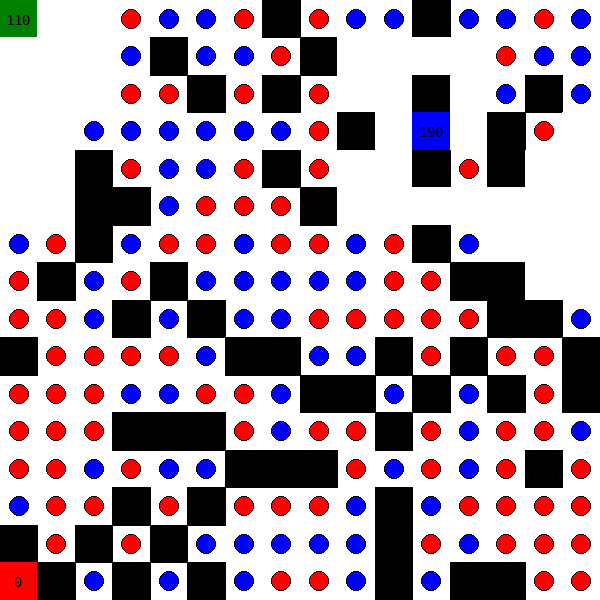

--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
--------- SOURCING PRODUCTIONS ------------
Total: 4 productions sourced.
west <<<<has item>>>> bonusfood
east <<<<has item>>>> 
south <<<<has item>>>> bonusfood
north <<<<has item>>>> normalfood
west <<<<has item>>>> 
east <<<<has item>>>> wall
south <<<<has item>>>> 
north <<<<has item>>>> wall
west <<<<has item>>>> bonusfood
east <<<<has item>>>> bonusfood
south <<<<has item>>>> normalfood
north <<<<has item>>>> normalfood
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> None
	OBSERVATIONS blue >>> {'north': 'normalfood', 'south': 'bonusfood', 'east': '', 'west': 'bonusfood'}
On output event
	Set last move output north
////// Updating north

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> east
	OBSERVATIONS blue >>> {'north': 'blank', 'south': 'normalfood', 'east': '', 'west': 'blank'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> blank
south <<<<has item>>>> normalfood
east <<<<has item>>>> 
west <<<<has item>>>> blank
On output event
	Set last move output south
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south': '', 'east': 'wall'

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> west
	OBSERVATIONS blue >>> {'north': 'normalfood', 'south': 'wall', 'east': 'blank', 'west': 'normalfood'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> normalfood
south <<<<has item>>>> wall
east <<<<has item>>>> blank
west <<<<has item>>>> normalfood
On output event
	Set last move output north
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south': 

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> west
	OBSERVATIONS blue >>> {'north': 'normalfood', 'south': 'bonusfood', 'east': 'blank', 'west': 'bonusfood'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> normalfood
south <<<<has item>>>> bonusfood
east <<<<has item>>>> blank
west <<<<has item>>>> bonusfood
On output event
	Set last move output west
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 's

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> north
	OBSERVATIONS blue >>> {'north': 'bonusfood', 'south': 'blank', 'east': 'bonusfood', 'west': 'wall'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> bonusfood
south <<<<has item>>>> blank
east <<<<has item>>>> bonusfood
west <<<<has item>>>> wall
On output event
	Set last move output north
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south': '',

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> east
	OBSERVATIONS blue >>> {'north': 'normalfood', 'south': 'blank', 'east': 'normalfood', 'west': 'blank'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> normalfood
south <<<<has item>>>> blank
east <<<<has item>>>> normalfood
west <<<<has item>>>> blank
On output event
	Set last move output east
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south':

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> south
	OBSERVATIONS blue >>> {'north': 'blank', 'south': 'bonusfood', 'east': 'wall', 'west': 'bonusfood'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> blank
south <<<<has item>>>> bonusfood
east <<<<has item>>>> wall
west <<<<has item>>>> bonusfood
On output event
	Set last move output west
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south': '', 

-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION blue >>> None
	OBSERVATIONS blue >>> {'north': 'wall', 'south': 'wall', 'east': 'blank', 'west': 'blank'}
////// Updating north
////// Updating south
////// Updating east
////// Updating west
north <<<<has item>>>> wall
south <<<<has item>>>> wall
east <<<<has item>>>> blank
west <<<<has item>>>> blank
////// Updating north
////// Updating south
////// Updating east
////// Updating west
-----------------------------------------------------------------------------
-------------------------- STEP ---------------------------------------------
-----------------------------------------------------------------------------
ACTION red >>> None
	OBSERVATIONS red >>> {'north': 'wall', 'south': '', 'east': 'wall', 'west': ''}
////// Updating north
////// Updat

KeyboardInterrupt: 

In [40]:
d = display.display("z", display_id=True)

world = World(d, width=600, height=600, rows=16, cols=16)

eaters = [
    Eater('blue', simple_move_to_food_agent, world, watch_level=0),
    Eater('red', simple_move_to_food_agent, world, watch_level=0),
    Eater('green', simple_move_to_food_agent, world, watch_level=0),
]

world.place_eaters(eaters)

# Set intial eater WM
for e in eaters:
    pos, cell = world.find(e.ID)    
    observations = world.observations(pos[0], pos[1])
    e.update_wm_from_observations(observations)
    e.step()
    
world.draw()
for i in range(100):
    
    for eater in eaters:
        print('-----------------------------------------------------------------------------')
        print('-------------------------- STEP ---------------------------------------------')
        print('-----------------------------------------------------------------------------')
        action = eater.get_move()
        
        # TODO: Not sure why adding this makes it work
        # Have to set these to null so that there isn't a state no change
        eater.update_wm_from_observations({
            'north': 'null',
            'south': 'null',
            'east': 'null',
            'west': 'null',
        })
        
        print(f"ACTION {eater.ID} >>> {action}")
        observations, reward = world.step(eater.ID, action)
        eater.points += reward
        print(f"\tOBSERVATIONS {eater.ID} >>>", observations)
        eater.update_wm_from_observations(observations)
        # Propose new move operator
        eater.step()
        # Apply new move operator, triggering an output link
        eater.step()
        
    
    world.draw()
    sleep(1)

In [ ]:

#move_simple_agentUse the "Add working memory" command to manually inject a working element into the agent
# This is often used to give Soar knowledge of the outside world
# move_simple_agent.execute_command("add-wme S1 ^io input-link +", print_res=True);
# move_simple_agent.execute_command("add-wme S1 ^io.input-link dir +", print_res=True);
# move_simple_agent.execute_command("step", print_res=True)
# move_simple_agent.execute_command("step", print_res=True);